In [1396]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import git, os, requests, json, pickle
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import k_means
from scipy.optimize import curve_fit
from scipy.special import factorial

# Loading data, creation of basic features

In [1334]:
years = [2017, 2018, 2019, 2020]
raw_data = {}
people = {}
for year in years:
    current_raw_data = pd.read_csv('rumors/data/rm'+str(year)+'.csv',sep=',',encoding='latin')
    raw_data[year] = current_raw_data
    people[year] = current_raw_data.sort_values(['Inspire link'])['Inspire link'].unique()

Dictionary to map special status (eg "Fancy fellowship, Offered/Accepted/Declined") into "Offered/Accepted/Declined, Special"

In [1337]:
status_dict = {}
for year in years:
    statuses = np.copy(raw_data[year]['Status'].unique())
    statuses_clean = []
    
    for status in statuses:
        if status == 'Offered': statuses_clean.append('Offered')
        elif status == 'Accepted': statuses_clean.append('Accepted')
        elif status == 'Declined': statuses_clean.append('Declined')
        elif status.find('Offered')>0: statuses_clean.append('Offered, Special')
        elif status.find('Accepted')>0: statuses_clean.append('Accepted, Special')
        elif status.find('Declined')>0: statuses_clean.append('Declined, Special') 
        else: statuses_clean.append('Unreadable')
            
    status_dict[year]=dict(zip(statuses,statuses_clean))
    

In [1343]:
number_of_offers = {}
data = {}
for year in years:
    number_of_offers[year] = [len(raw_data[year][raw_data[year]['Inspire link']==person]['Institution'].unique()) for person in people[year]]
    data[year] = pd.DataFrame(people[year],columns=['Person'])

In [1383]:
inspire_data = {}
for year in years:
    inspire_data[year] = []
    for person in people[year]:
        response = requests.get(f"http://old.inspirehep.net/search?p=ea:{person}+and+d+<+{year}+&rg=75&of=recjson&ot=recid,creation_date,number_of_authors,number_of_citations,authors")
        inspire_data[year].append(json.loads(response.text))
    print(year)

2017
2018
2019
2020


In [1401]:
paper_series = {}
for year in years:
    paper_series[year] = pd.Series(dict(zip(people[year],inspire_data[year])))

In [1485]:
def get_citations(paper, year):
    rec = paper['recid']
    response = requests.get(f"http://old.inspirehep.net/search?p=refersto:recid:{rec}+and+d+<{year}+&rg=250&of=recjson&ot=recid")
    return len(json.loads(response.text))

Save the Inspire data dictionary in a file. Data takes a long time to download, so avoid re-running.

In [1404]:
for year in years:
    paper_series[year].to_pickle('rumors/data/paper_series'+str(year))

Load file from above into a dictionary. If needed, load into "downloaded_data".

In [1405]:
s2018 = pd.read_pickle('rumors/data/paper_series2018')

This function creates all features from the downloaded InspireHEP data

In [1414]:
def analyze(person, paper_series, year):
    return_dict = {}
    #frame_incl_recent = pd.DataFrame(paper_series[person],columns=['creation_date','number_of_authors','number_of_citations'])
    frame = pd.DataFrame(paper_series,columns=['creation_date','number_of_authors','number_of_citations'])# frame_incl_recent[pd.to_datetime(frame_incl_recent['creation_date']) < pd.to_datetime('01/01/2020')]
    
    paper_dates = np.array([pd.to_datetime(paper['creation_date']) for paper in paper_series])
    
    author_lists = [paper['authors'] for paper in paper_series]
    affiliations = []
    
    for author_list in author_lists:

        author_frame = pd.DataFrame(author_list)
        try: 
            affiliation = author_frame[author_frame['full_name'].str.contains(person.split('.')[-2])]['affiliation'].values
            if type(affiliation) == str:
                affiliations.append(affiliation.lower().strip())
            else:
                for aff in affiliation: affiliations.append(aff.lower().replace('(main)','').strip())
        except: continue 

            
    #affiliations = np.array(affiliations).flatten()
    
    return_dict['papers_total'] = len(frame)
    return_dict['citations_total'] = frame['number_of_citations'].sum()
    return_dict['citations_median'] = frame['number_of_citations'].median()
    return_dict['citations_max'] = frame['number_of_citations'].max()
    return_dict['collaboration'] = frame['number_of_authors'].max()>15
    return_dict['citations_per_paper'] = frame['number_of_citations'].mean()
    return_dict['papers_last_year'] = len(frame[pd.to_datetime(frame['creation_date']) > pd.to_datetime('01/01/2019')])
    return_dict['papers_three_years'] = len(frame[pd.to_datetime(frame['creation_date']) > pd.to_datetime('01/01/2016')])
    return_dict['affiliations'] = np.unique(np.array(affiliations))
    return_dict['affiliations_total'] = len(np.unique(affiliations))
    
    return_dict['offers'] = len(raw_data[year][raw_data[year]['Inspire link']==person]['Institution'].unique())

    
    if len(paper_dates)>1:
        return_dict['time_since_paper2'] = (pd.to_datetime('01/01/'+str(year))-np.sort(paper_dates)[1]).days/365.
        return_dict['time_since_paper1'] = (pd.to_datetime('01/01/'+str(year))-np.sort(paper_dates)[0]).days/365.
    else:
        return_dict['time_since_paper2'] = 0.
        return_dict['time_since_paper1'] = 0.
    return return_dict

In [1494]:
analyze(people[2017][0], paper_series[2017][people[2017][0]], 2017)

{'papers_total': 3,
 'citations_total': 279,
 'citations_median': 42.0,
 'citations_max': 232,
 'collaboration': False,
 'citations_per_paper': 93.0,
 'papers_last_year': 0,
 'papers_three_years': 0,
 'affiliations': array(['orsay, lpt'], dtype='<U10'),
 'affiliations_total': 1,
 'offers': 1,
 'time_since_paper2': 1.0602739726027397,
 'time_since_paper1': 1.180821917808219}

In [1497]:
analyzed_data = {}
for year in years:
    analyzed_data[year] = pd.DataFrame([analyze(person, paper_series[year][person], year) for person in people[year]], people[year])
    if input(f'Number of entries with a NAN: {len(analyzed_data[year])-len(analyzed_data[year].dropna())}. Drop? y/n >')=='y':
        analyzed_data[year] = analyzed_data[year].dropna()

Number of entries with a NAN: 14. Drop? y/n >y
Number of entries with a NAN: 11. Drop? y/n >y
Number of entries with a NAN: 9. Drop? y/n >y
Number of entries with a NAN: 3. Drop? y/n >y


# Visualization of available data

In [1013]:
analyzed_data.head()

,affiliations,affiliations_total,citations_max,citations_median,citations_per_paper,citations_total,collaboration,offers,papers_last_year,papers_three_years,papers_total,time_since_paper1,time_since_paper2
A.Aboubrahim.1,"[beirut arab u., northeastern u.]",2,163.0,11.0,23.411765,398,True,2,5,12,17,6.558904,6.060274
A.Banerjee.6,[saha inst.],1,17.0,6.0,8.800000,44,False,1,2,5,5,2.772603,2.027397
A.Bhatta.1,"[bangalore, indian inst. sci., imsc, chennai]",2,38.0,1.5,9.166667,55,False,1,3,6,6,3.890411,3.205479
A.Biswas.2,"[harish-chandra res. inst., iacs, kolkata, ind...",4,55.0,12.0,17.080000,427,False,1,3,19,25,8.882192,6.961644
A.Carosso.1,[colorado u.],1,16.0,2.0,4.600000,23,False,1,2,5,5,1.975342,1.569863


## Role of collaboration ?

In [1506]:
analyzed_data[2020]['collaboration'].sum()/len(analyzed_data[2020])

0.21235521235521235

In [1508]:
def comparison_hist(feature, year):
    analyzed_data[year][analyzed_data[year]['collaboration']==True][feature].hist(density=True, color='blue', alpha=0.5, label='Collab.')
    analyzed_data[year][analyzed_data[year]['collaboration']==False][feature].hist(alpha=0.5, density=True, color='red', label='No collab')
    plt.axvline(analyzed_data[year][analyzed_data[year]['collaboration']==True][feature].median(), color='blue',lw=2)
    plt.axvline(analyzed_data[year][analyzed_data[year]['collaboration']==False][feature].median(), color='red',lw=2)
    plt.legend()

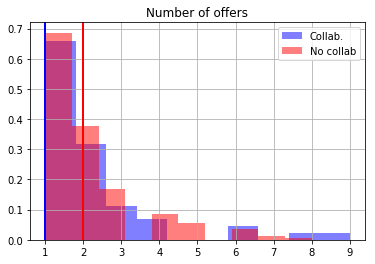

In [1510]:
comparison_hist('offers', 2020)
plt.title('Number of offers');